In [ ]:
# https://github.com/hoseinzadeehsan/CNNpred-Keras

### **Prédire la direction du marché boursier pour le lendemain** (c'est-à-dire, à la hausse ou à la baisse par rapport à aujourd'hui), il s'agit donc d'un problème de classification binaire. Cependant, il est intéressant de voir comment ce problème est formulé et résolu.

### Si nous considérons le Dow Jones Industrial Average (DJIA) comme exemple, nous pouvons **construire un CNN avec une convolution 1D pour la prédiction**. Cela a du sens car une convolution 1D sur une série chronologique calcule approximativement sa moyenne mobile ou utilise des termes de traitement de signal numérique, **en appliquant un filtre à la série chronologique**. Il devrait fournir quelques indices sur la tendance.

### Cependant, lorsque nous examinons les séries chronologiques financières, il est tout à fait logique que **certains signaux dérivés soient également utiles pour les prédictions**. Par exemple, l**e prix et le volume combinés peuvent fournir un meilleur indice**. Certains autres indicateurs techniques tels que **la moyenne mobile de différentes tailles de fenêtre sont également utiles**. Si nous rassemblons tous ces éléments, nous aurons une table de données, qui à chaque instance a plusieurs fonctionnalités , et **l'objectif est toujours de prédire la direction d' une série temporelle**

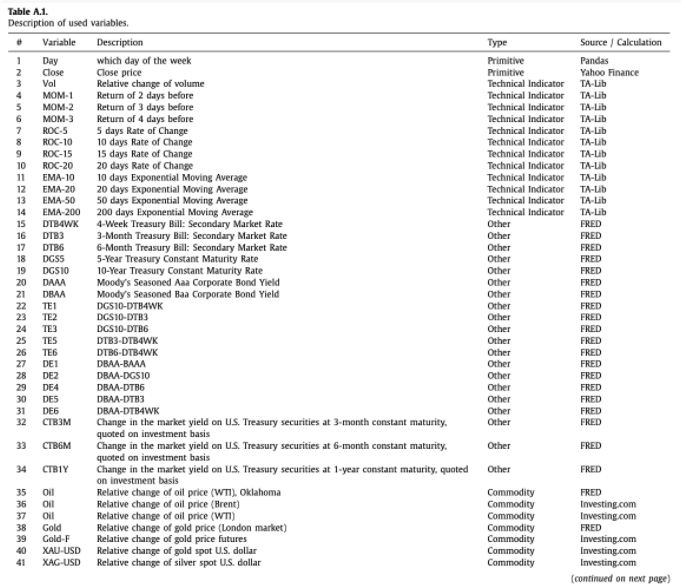

### **Les données d'entrée ont une colonne de date et une colonne de nom** pour identifier le symbole boursier de l'indice de marché. Nous pouvons laisser la colonne de date comme index de temps et supprimer la colonne de nom. Les autres sont tous numériques.

### Comme nous allons prédire l'orientation du marché, nous essayons d'abord de créer l'étiquette de classification. La direction du marché est définie comme l'indice de clôture de demain par rapport à aujourd'hui. Si nous avons lu les données dans un DataFrame pandas, nous pouvons les utiliser X["Close"].pct_change()pour trouver le pourcentage de changement, qui augmente un changement positif pour le marché. Nous pouvons donc changer cela en un pas en arrière en tant que notre étiquette 

### **Le modèle**
### Le modèle CNN 2D présenté dans l'article original accepte un tenseur de forme d'entrée pour N le nombre de pas de temps et m le nombre d'entités dans chaque pas de temps. Le papier suppose et .

### Le modèle comprend trois couches convolutives, décrites comme suit :

Nous avons fourni "acc" comme précision ainsi que la fonction f1macro définie ci-dessus comme paramètre de métrique de la fonction compile(). Par conséquent, ces deux métriques seront surveillées pendant la formation. Étant donné que la fonction est nommée f1macro, nous nous référons à cette métrique dans le paramètre de surveillance du point de contrôle comme val_f1macro.

Séparément, dans la fonction fit(), nous avons fourni les données d'entrée via le générateur datagen() tel que défini ci-dessus. L'appel de cette fonction produira un générateur qui, pendant la boucle d'apprentissage, en extrait les lots les uns après les autres. De même, des données de validation sont également fournies par le générateur.

Parce que la nature d'un générateur est d'envoyer des données indéfiniment. Nous devons expliquer au processus de formation comment définir une époque. Rappelez-vous qu'en termes Keras, un lot est une itération de mise à jour de la descente de gradient. Une époque est censée être un cycle à travers toutes les données de l'ensemble de données. À la fin d'une époque, il est temps d'exécuter la validation. C'est aussi l'occasion d'exécuter le point de contrôle que nous avons défini plus haut. Comme Keras n'a aucun moyen de déduire la taille de l'ensemble de données à partir d'un générateur, nous devons indiquer le nombre de lots qu'il doit traiter en une époque à l'aide du paramètre steps_per_epoch. De même, c'est le paramètre validation_steps qui indique combien de lots sont utilisés dans chaque étape de validation. La validation n'affecte pas la formation, mais elle nous rapportera les métriques qui nous intéressent. 

In [ ]:
import os
import random
 
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error
 
#from f1metrics import f1macro
 
DATADIR = '/content/drive/MyDrive/14_NEW PROJECT CRYPTO/Etude Financière/Dataset'
TRAIN_TEST_CUTOFF = '2016-04-21'
TRAIN_VALID_RATIO = 0.75
 
# https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
# to implement F1 score for validation in a batch
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
 
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
 
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
 
def f1macro(y_true, y_pred):
    f_pos = f1_m(y_true, y_pred)
    # negative version of the data and prediction
    f_neg = f1_m(1-y_true, 1-K.clip(y_pred,0,1))
    return (f_pos + f_neg)/2
 
def cnnpred_3d(seq_len=60, n_stocks=5, n_features=82, n_filters=(8,8,8), droprate=0.1):
    "3D-CNNpred model according to the paper"
    model = Sequential([
        Input(shape=(n_stocks, seq_len, n_features)),
        Conv2D(n_filters[0], kernel_size=(1,1), activation="relu", data_format="channels_last"),
        Conv2D(n_filters[1], kernel_size=(n_stocks,3), activation="relu"),
        MaxPool2D(pool_size=(1,2)),
        Conv2D(n_filters[2], kernel_size=(1,3), activation="relu"),
        MaxPool2D(pool_size=(1,2)),
        Flatten(),
        Dropout(droprate),
        Dense(1, activation="sigmoid")
    ])
    return model
 
def datagen(data, seq_len, batch_size, target_index, targetcol, kind):
    "As a generator to produce samples for Keras model"
    # Learn about the data's features and time axis
    input_cols = [c for c in data.columns if c[0] != targetcol]
    tickers = sorted(set(c for _,c in input_cols))
    n_features = len(input_cols) // len(tickers)
    index = data.index[data.index < TRAIN_TEST_CUTOFF]
    split = int(len(index) * TRAIN_VALID_RATIO)
    assert split > seq_len, "Training data too small for sequence length {}".format(seq_len)
    if kind == "train":
        index = index[:split]   # range for the training set
    elif kind == 'valid':
        index = index[split:]   # range for the validation set
    else:
        raise NotImplementedError
    # Infinite loop to generate a batch
    batch = []
    while True:
        # Pick one position, then clip a sequence length
        while True:
            t = random.choice(index)
            n = (data.index == t).argmax()
            if n-seq_len+1 < 0:
                continue # this sample is not enough for one sequence length
            frame = data.iloc[n-seq_len+1:n+1][input_cols]
            # convert frame with two level of indices into 3D array
            shape = (len(tickers), len(frame), n_features)
            X = np.full(shape, np.nan)
            for i,ticker in enumerate(tickers):
                X[i] = frame.xs(ticker, axis=1, level=1).values
            batch.append([X, data[targetcol][target_index][t]])
            break
        # if we get enough for a batch, dispatch
        if len(batch) == batch_size:
            X, y = zip(*batch)
            yield np.array(X), np.array(y)
            batch = []
 
def testgen(data, seq_len, target_index, targetcol):
    "Return array of all test samples"
    input_cols = [c for c in data.columns if c[0] != targetcol]
    tickers = sorted(set(c for _,c in input_cols))
    n_features = len(input_cols) // len(tickers)
    t = data.index[data.index >= TRAIN_TEST_CUTOFF][0]
    n = (data.index == t).argmax()
    batch = []
    for i in range(n+1, len(data)+1):
        # Clip a window of seq_len ends at row position i-1
        frame = data.iloc[i-seq_len:i]
        target = frame[targetcol][target_index][-1]
        frame = frame[input_cols]
        # convert frame with two level of indices into 3D array
        shape = (len(tickers), len(frame), n_features)
        X = np.full(shape, np.nan)
        for i,ticker in enumerate(tickers):
            X[i] = frame.xs(ticker, axis=1, level=1).values
        batch.append([X, target])
    X, y = zip(*batch)
    return np.array(X), np.array(y)
 
# Read data into pandas DataFrames
data = {}
for filename in os.listdir(DATADIR):
    if not filename.lower().endswith(".csv"):
        continue # read only the CSV files
    filepath = os.path.join(DATADIR, filename)
    X = pd.read_csv(filepath, index_col="Date", parse_dates=True)
    # basic preprocessing: get the name, the classification
    # Save the target variable as a column in dataframe for easier dropna()
    name = X["Name"][0]
    del X["Name"]
    cols = X.columns
    X["Target"] = (X["Close"].pct_change().shift(-1) > 0).astype(int)
    X.dropna(inplace=True)
    # Fit the standard scaler using the training dataset
    index = X.index[X.index < TRAIN_TEST_CUTOFF]
    index = index[:int(len(index) * TRAIN_VALID_RATIO)]
    scaler = StandardScaler().fit(X.loc[index, cols])
    # Save scale transformed dataframe
    X[cols] = scaler.transform(X[cols])
    data[name] = X
 
# Transform data into 3D dataframe (multilevel columns)
for key, df in data.items():
    df.columns = pd.MultiIndex.from_product([df.columns, [key]])
data = pd.concat(data.values(), axis=1)
 
seq_len    = 60
batch_size = 128
n_epochs   = 20
n_features = 82
n_stocks   = 5
 
# Produce CNNpred as a binary classification problem
model = cnnpred_3d(seq_len, n_stocks, n_features)
model.compile(optimizer="adam", loss="mae", metrics=["acc", f1macro])
model.summary() # print model structure to console
 
# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp3d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max", verbose=0,
                    save_best_only=True, save_weights_only=False, save_freq="epoch")
]
 
model.fit(datagen(data, seq_len, batch_size, "DJI", "Target", "train"),
          validation_data=datagen(data, seq_len, batch_size, "DJI", "Target", "valid"),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)
 
# Prepare test data
test_data, test_target = testgen(data, seq_len, "DJI", "Target")
 
# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy:", accuracy_score(test_pred, test_target))
print("MAE:", mean_absolute_error(test_pred, test_target))
print("F1:", f1_score(test_pred, test_target))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 5, 60, 8)          664       
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 58, 8)          968       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 29, 8)         0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 27, 8)          200       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 13, 8)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 104)               0

Est-ce que ça marche?
Comme dans tous les projets de prédiction sur le marché financier, il est toujours irréaliste de s'attendre à une grande précision. Le paramètre d'entraînement dans le code ci-dessus peut produire un peu plus de 50 % de précision dans l'ensemble de test. Bien que le nombre d'époques et la taille des lots soient délibérément réduits pour gagner du temps, il ne devrait pas y avoir beaucoup de place pour l'amélioration.
